## SleepStudy Multilevel Models using Bambi

This is a translation of the Exercise: Linear Multilevel Models. From brms to Bambi

In [1]:
import bambi as bmb
import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import some custom functions
import sys
sys.path.append('./utils/')
from plotting_utils import plot_linear_regression, plot_individual_sleep_data
from trace_utils import get_intercepts, get_coefs

%matplotlib inline
#Set plotting options
sns.set_context('talk')
sns.set_style('darkgrid', {"axes.facecolor": ".9"})

#KeyWord arguments used to adjust bambi default params to brms
brms_args = {'draws': 2000,
             'tune': 2000,
             'chains': 4,
             'target_accept': 0.95} #check if thats actually correct

In [2]:
#Get the sleepstudy data from somewhere
sleepstudy = pd.read_csv('https://www.picostat.com/system/files/datasets/dataset-85663.csv')

In [3]:
model_sleep1 = bmb.Model('Reaction ~ 1 + Days', data=sleepstudy) #specify a model
fit_sleep1 = model_sleep1.fit(**brms_args) #fit it

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Reaction_sigma, Days, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 60 seconds.


In [4]:
#Summarize results:
az.summary(fit_sleep1)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,251.457,6.722,239.222,264.301,0.082,0.058,6812.0,5293.0,1.0
Days,10.450,1.252,8.017,12.735,0.015,0.011,7041.0,5353.0,1.0
Reaction_sigma,47.944,2.593,43.320,52.914,0.031,0.022,7136.0,5222.0,1.0


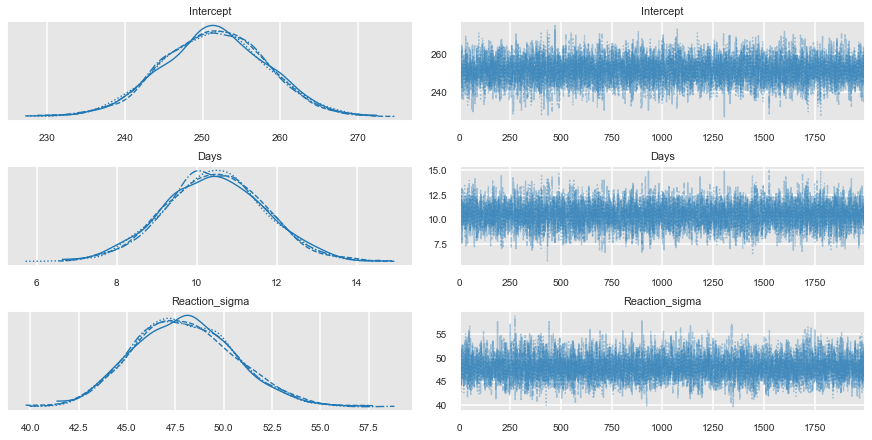

In [5]:
az.plot_trace(fit_sleep1);

In [6]:
model_sleep1.predict(fit_sleep1)

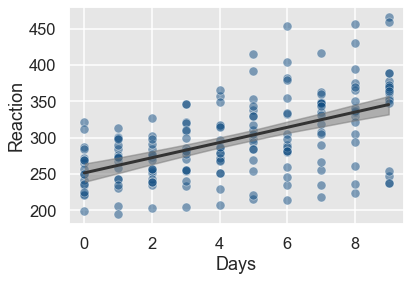

In [7]:
g = plot_linear_regression(sleepstudy, fit_sleep1, 'Days', 'Reaction')

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


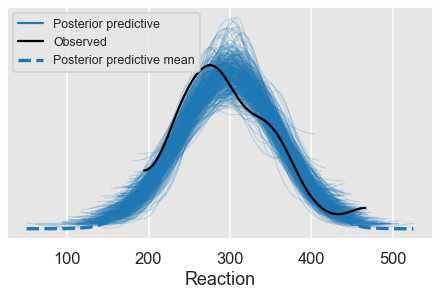

In [8]:
model_sleep1.predict(fit_sleep1, kind="pps", draws=100)#posterior predictive checks
az.plot_ppc(fit_sleep1);

In [9]:
#partial pooling: individual intercept, common slope:
model_sleep2 = bmb.Model('Reaction ~ 1 + Days + (1|Subject)', data=sleepstudy) #specify a model
fit_sleep2 = model_sleep2.fit(**brms_args) #fit it

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [Reaction_sigma, 1|Subject_offset, 1|Subject_sigma, Days, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 89 seconds.
The number of effective samples is smaller than 10% for some parameters.


In [10]:
summary_2 = az.summary(fit_sleep2, kind='stats')
intercepts_2 = get_intercepts(summary_2, '1|Subject')

In [ ]:
az.plot_trace(fit_sleep2);

In [ ]:
model_sleep2.predict(fit_sleep2)

In [ ]:
g = plot_linear_regression(sleepstudy, fit_sleep2, 'Days', 'Reaction', random_factor='Subject')

In [ ]:
#Extract effects of each Subject:
plot_individual_sleep_data(sleepstudy, fit_sleep2);

In [ ]:
model_sleep2.predict(fit_sleep2, kind="pps", draws=100) #compute posterior predictive checks
az.plot_ppc(fit_sleep2);

In [ ]:
#Partial pooling: individual intercept AND slope:
model_sleep3 = bmb.Model('Reaction ~ 1 + Days + (1 + Days | Subject)', data = sleepstudy)
fit_sleep3 = model_sleep3.fit(**brms_args) #fit it

In [ ]:
summary3 = az.summary(fit_sleep3, kind='stats')
intercepts3 = get_intercepts(summary3, '1|Subject')
Days3 = get_coefs(summary3, 'Days', 'Days|Subject')

In [ ]:
intercepts3

In [ ]:
summary3[summary3.index.str.find('Days|Subject')] + summary3.loc['Days']

In [ ]:
intercepts3

In [ ]:
az.plot_trace(fit_sleep3);

In [ ]:
model_sleep3.predict(fit_sleep3)

In [ ]:
g = plot_linear_regression(sleepstudy, fit_sleep3, 'Days', 'Reaction', random_factor='Subject')

In [ ]:
#Extract effects of each Subject:
plot_individual_sleep_data(sleepstudy, fit_sleep3);

In [ ]:
model_sleep3.predict(fit_sleep3, kind="pps", draws=100) #compute posterior predictive checks
az.plot_ppc(fit_sleep3);

In [ ]:
#Compare all trhee models:
models = {
    "fixed_intercept_fixed_slope": fit_sleep1,
    "random_intercept_fixed_slope": fit_sleep2,
    "random_intercept_random_slope": fit_sleep3,
}
df_compare = az.compare(models)
df_compare

In [ ]:
az.plot_compare(df_compare, insample_dev=False);